In [ ]:
import pandas as pd
import numpy as np

# Number of samples
n_samples = 3000

# Realistic Gas Sensor Behavior
# In normal air, MQ2 gas level is low (200–400)
# During cooking or leak (hazard), it can spike (800–1200+)
gas_level = np.random.normal(350, 100, n_samples).clip(100, 1000)

# Add occasional gas spikes (simulate hazard)
for i in np.random.choice(range(n_samples), size=300, replace=False):
    gas_level[i] = np.random.uniform(900, 1300)

# Other sensor values (stable)
temperature = np.random.uniform(20, 45, n_samples)  # °C
humidity = np.random.uniform(30, 90, n_samples)     # %
weight = np.random.uniform(0, 2000, n_samples)      # grams
distance = np.random.uniform(2, 400, n_samples)     # cm

# Label Logic (Safe / Hazard)
labels = []
safe_count = 0
haz_count = 0

for t, h, g, w, d in zip(temperature, humidity, gas_level, weight, distance):
    if g > 900 or t > 42 or w > 1800:
        labels.append(1)  # Hazard
        haz_count += 1
    else:
        labels.append(0)  # Safe
        safe_count += 1

# Create DataFrame
data = pd.DataFrame({
    'temperature': temperature,
    'humidity': humidity,
    'gas_level': gas_level,
    'weight': weight,
    'distance': distance,
    'hazard': labels
})

# Shuffle
data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Save
data.to_csv("sensor_data.csv", index=False)

# Print Stats
print("Realistic Gas Level Dataset Generated!")
print(f"Total Samples: {len(data)} | Safe: {safe_count} | Hazard: {haz_count}")
print(f"Gas Level → Min: {data['gas_level'].min():.2f}, Max: {data['gas_level'].max():.2f}")
print("\nSample Data:")
print(data.head())

Realistic Gas Level Dataset Generated!
Total Samples: 3000 | Safe: 2125 | Hazard: 875
Gas Level → Min: 100.00, Max: 1299.95

Sample Data:
   temperature   humidity   gas_level       weight    distance  hazard
0    40.554367  70.741901  342.821848  1223.121771  362.227631       0
1    41.039108  79.729127  548.771860   743.275804    9.749536       0
2    36.824694  39.227980  373.704884  1475.612289  369.499355       0
3    40.258026  56.214877  415.396710  1205.363594  344.098875       0
4    36.192025  51.355735  358.634863  1409.467806   90.691674       0


# Training Data

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv("/content/sensor_data.csv")

# Feature columns
FEATURES = ['temperature', 'humidity', 'gas_level', 'weight', 'distance']
X = data[FEATURES]
y = data['hazard']

# Min-Max Normalization (float model expects normalized values)
X_min = X.min()
X_max = X.max()
X_norm = (X - X_min) / (X_max - X_min)

# Save min/max values for deployment normalization on ESP32
np.savetxt("feature_mins.txt", X_min.values, fmt="%.6f")
np.savetxt("feature_maxs.txt", X_max.values, fmt="%.6f")

print("Feature Ranges:")
print("Min:\n", X_min)
print("\nMax:\n", X_max)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_norm.values, y, test_size=0.2, random_state=42, stratify=y
)

# Build a Lightweight Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nModel Evaluation Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save Float Model
model.save("model.keras")
print("\nModel saved as 'model.keras'.")

Feature Ranges:
Min:
 temperature     20.005821
humidity        30.029383
gas_level      100.000000
weight           0.237705
distance         2.087296
dtype: float64

Max:
 temperature      44.992456
humidity         89.934978
gas_level      1299.947479
weight         1999.771729
distance        399.991531
dtype: float64
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6984 - loss: 0.6465 - val_accuracy: 0.6917 - val_loss: 0.6094
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7467 - loss: 0.5627 - val_accuracy: 0.7604 - val_loss: 0.5508
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8004 - loss: 0.4952 - val_accuracy: 0.7812 - val_loss: 0.5004
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8151 - loss: 0.4402 - val_accuracy: 0.8042 - val_loss: 0.4454
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8442 - loss: 0.3826 - val_accuracy: 0.8250 - val_loss: 0.4081
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

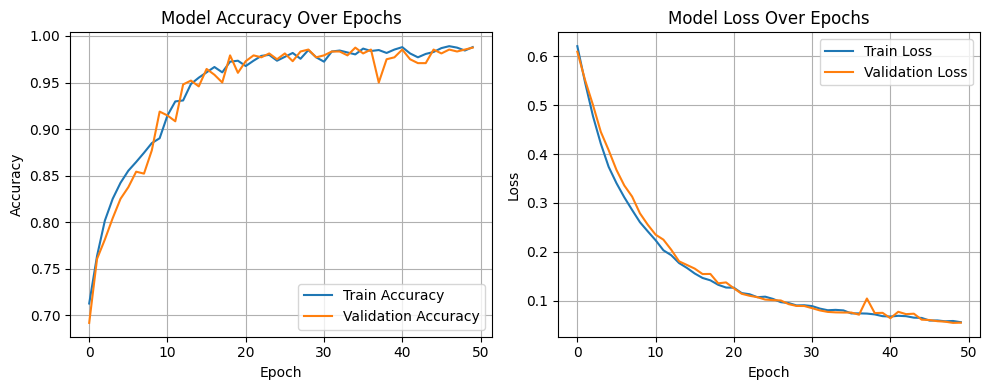

In [ ]:
# Plot both accuracy and loss

plt.figure(figsize=(10, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Quantize your model

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Load trained model
model = tf.keras.models.load_model("/content/model.keras")

# Load dataset for calibration
data = pd.read_csv("/content/sensor_data.csv")
FEATURES = ['temperature', 'humidity', 'gas_level', 'weight', 'distance']
X = data[FEATURES].values.astype(np.float32)

# Load min/max used during training
X_min = np.loadtxt("/content/feature_mins.txt", dtype=np.float32)
X_max = np.loadtxt("/content/feature_maxs.txt", dtype=np.float32)

# Normalize same as training
X_norm = (X - X_min) / (X_max - X_min)
X_norm = np.clip(X_norm, 0, 1)

# Scale to [-1, 1] since int8 quantization expects zero-centered data
X_scaled = (X_norm * 2) - 1

# Representative dataset generator
def representative_data_gen():
    for i in range(100):
        sample = X_scaled[np.random.choice(len(X_scaled), 1)]
        yield [sample.astype(np.float32)]

# TFLite conversion (fully INT8)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Force full INT8 model (including input/output)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert
int8_model = converter.convert()

# Save the model
with open("model.tflite", "wb") as f:
    f.write(int8_model)

print("Fully INT8 quantized model saved as model.tflite")

Saved artifact at '/tmp/tmpc9bxfcy4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136601453913360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136601453907984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136601453919888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136601453915664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136601453908560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136601453908368: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fully INT8 quantized model saved as model.tflite


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
import tensorflow as tf

# Load your quantized TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Tensor Details")
print(f"Name: {input_details[0]['name']}")
print(f"Shape: {input_details[0]['shape']}")
print(f"Dtype: {input_details[0]['dtype']}")
print(f"Quantization: {input_details[0]['quantization']}")

print("\nOutput Tensor Details")
print(f"Name: {output_details[0]['name']}")
print(f"Shape: {output_details[0]['shape']}")
print(f"Dtype: {output_details[0]['dtype']}")
print(f"Quantization: {output_details[0]['quantization']}")

Input Tensor Details
Name: serving_default_input_layer_9:0
Shape: [1 5]
Dtype: <class 'numpy.int8'>
Quantization: (0.007817231118679047, -1)

Output Tensor Details
Name: StatefulPartitionedCall_1:0
Shape: [1 1]
Dtype: <class 'numpy.int8'>
Quantization: (0.00390625, -128)


In [ ]:
!xxd -i /content/model.tflite > model.h